<a href="https://colab.research.google.com/github/jc890/python/blob/master/HRanalyticsCodingassessment01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# ==========================================
# HR Analytics - Promotion Prediction (IWCSF F1)
# ==========================================

# STEP 0: Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
import lightgbm as lgb

# ==========================================
# STEP 1: Load Data
# ==========================================
train = pd.read_csv('/content/train_LZdllcl.csv')
test = pd.read_csv('/content/test_2umaH9m.csv')
sample = pd.read_csv('/content/sample_submission_M0L0uXE.csv')


Target distribution:
 is_promoted
0    0.91483
1    0.08517
Name: proportion, dtype: float64


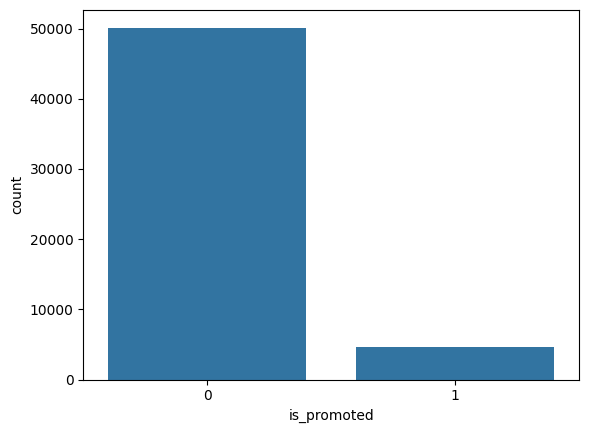

In [3]:

# ==========================================
# STEP 2: EDA (optional for visualization)
# ==========================================
print("Target distribution:\n", train['is_promoted'].value_counts(normalize=True))
sns.countplot(x='is_promoted', data=train)
plt.show()



In [4]:
# ==========================================
# STEP 3: Preprocessing
# ==========================================
# Fill missing values
for col in ['education','previous_year_rating']:
    train[col].fillna(train[col].mode()[0] if train[col].dtype=='O' else train[col].median(), inplace=True)
    test[col].fillna(train[col].mode()[0] if train[col].dtype=='O' else train[col].median(), inplace=True)

# Feature engineering
for df in [train, test]:
    df['trainings_per_year'] = df['no_of_trainings'] / (df['length_of_service'] + 1)
    df['is_experienced'] = (df['length_of_service'] > 5).astype(int)
    df['is_high_perf'] = ((df['KPIs_met >80%'] == 1) & (df['previous_year_rating'] >= 4)).astype(int)
    df['region_freq'] = df['region'].map(train['region'].value_counts())
    df['region_freq'].fillna(0, inplace=True)

# Encode categorical features
cat_features = ['department','region','education','gender','recruitment_channel']
for col in cat_features:
    lbl = LabelEncoder()
    train[col] = lbl.fit_transform(train[col].astype(str))
    test[col] = lbl.transform(test[col].astype(str))

# Features and target
X = train.drop(['employee_id','is_promoted'], axis=1)
y = train['is_promoted']
X_test = test.drop(['employee_id'], axis=1)


/tmp/ipython-input-561172478.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train[col].fillna(train[col].mode()[0] if train[col].dtype=='O' else train[col].median(), inplace=True)
/tmp/ipython-input-561172478.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, whe

In [5]:

# ==========================================
# STEP 4: IWCSF-inspired Stochastic F1 Function
# ==========================================
thresholds = np.linspace(0.1, 0.9, 50)  # candidate thresholds
threshold_weights = np.ones(len(thresholds))  # start uniform
fold_thresholds = []

def lgb_f1_stochastic(y_pred, dataset, num_samples=20, decay=0.8):
    global thresholds, threshold_weights, fold_thresholds
    y_true = dataset.get_label()

    # Sample thresholds according to weighted probabilities
    prob_dist = threshold_weights / threshold_weights.sum()
    sampled_thresholds = np.random.choice(thresholds, size=num_samples, replace=True, p=prob_dist)

    best_f1 = 0
    best_thresh = 0
    for t in sampled_thresholds:
        f1 = f1_score(y_true, (y_pred > t).astype(int))
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

    # Update weights: decay all, reward best threshold
    idx = np.argmin(np.abs(thresholds - best_thresh))
    threshold_weights *= decay
    threshold_weights[idx] += 1

    fold_thresholds.append(best_thresh)
    return 'f1', best_f1, True


In [6]:

# ==========================================
# STEP 5: LightGBM Modeling
# ==========================================
params = {
    'objective':'binary',
    'boosting_type':'gbdt',
    'metric':'binary_logloss',  # required for training
    'num_leaves':31,
    'learning_rate':0.05,
    'feature_fraction':0.8,
    'bagging_fraction':0.8,
    'bagging_freq':5,
    'verbose':-1,
    'random_state':42
}

folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
oof_preds = np.zeros(len(train))
test_preds = np.zeros(len(test))

for fold, (train_idx, val_idx) in enumerate(folds.split(X, y)):
    print(f"\n---- Fold {fold+1} ----")
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    dtrain = lgb.Dataset(X_train, y_train)
    dval = lgb.Dataset(X_val, y_val, reference=dtrain)

    callbacks = [
        lgb.early_stopping(stopping_rounds=50, verbose=True),
        lgb.log_evaluation(period=100)
    ]

    model = lgb.train(
        params,
        dtrain,
        valid_sets=[dval],
        feval=lgb_f1_stochastic,
        callbacks=callbacks
    )

    val_pred = model.predict(X_val, num_iteration=model.best_iteration)
    test_pred = model.predict(X_test, num_iteration=model.best_iteration)

    oof_preds[val_idx] = val_pred
    test_preds += test_pred / folds.n_splits



---- Fold 1 ----
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.162306	valid_0's f1: 0.532365
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.162306	valid_0's f1: 0.532365

---- Fold 2 ----
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.170079	valid_0's f1: 0.489493
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.170079	valid_0's f1: 0.489493

---- Fold 3 ----
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.167639	valid_0's f1: 0.52461
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.167639	valid_0's f1: 0.52461

---- Fold 4 ----
Training until validation scores don't improve for 50 rounds
[100]	valid_0's binary_logloss: 0.162473	valid_0's f1: 0.540084
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.162473	valid

In [7]:

# ==========================================
# STEP 6: Final Threshold & Submission
# ==========================================
final_thresh = np.mean(fold_thresholds)
final_preds = (test_preds > final_thresh).astype(int)

submission = sample.copy()
submission['is_promoted'] = final_preds
submission.to_csv('submission.csv', index=False)

print("\n✅ Submission saved as 'submission.csv'")
print(f"Final Threshold: {final_thresh:.3f}")



✅ Submission saved as 'submission.csv'
Final Threshold: 0.215
